In [1]:
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras import layers
import os
import tifffile as tiff
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from preprocessing import normalizePercentile, unpatch_stack, predict_stack, patch_stack, patch_image, pad_stack, normalizeMinMax, threshold_prediction_array
from window_functions import build_weighted_mask_array
from patchify import patchify

if tf.test.gpu_device_name()=='':
    print('You do not have GPU access.')
    !nvidia-smi

else:
  print('You have GPU access')
  !nvidia-smi


# print the tensorflow version
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))
tf.test.gpu_device_name()


C:\Users\Jens\miniconda3\envs\tensorflow\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


You have GPU access
Mon Apr 10 12:06:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.37       Driver Version: 527.37       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   57C    P0    16W /  N/A |    174MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

'/device:GPU:0'

In [7]:
model_path = os.path.abspath("F:\BactUnet\models")

#load pretrained models
model_single_name = "bactunet_V4_single_frame"
model_3frame_name = "bactunet_V4_3frame"
model_empty_name = "bactunet_V4_3frame_empty_250ep"

model_single = load_model(os.path.join(model_path, model_single_name+".hdf5"), compile=False)
model_3frame = load_model(os.path.join(model_path, model_3frame_name+".hdf5"), compile=False)
model_empty = load_model(os.path.join(model_path, model_empty_name+".hdf5"), compile=False)

modelsdict = {model_single_name:model_single, model_3frame_name:model_3frame, model_empty_name:model_empty}

print(modelsdict.keys())


dict_keys(['bactunet_V4_single_frame', 'bactunet_V4_3frame', 'bactunet_V4_3frame_empty_250ep'])


In [8]:
#models are identical except for the input shape (1, 288, 288) vs (3, 288, 288)
for l1, l2 in zip(model_single.weights, model_3frame.weights):
    print(l1.name, l1.shape, l2.name, l2.shape)

conv2d/kernel:0 (3, 3, 1, 64) conv2d/kernel:0 (3, 3, 3, 64)
conv2d/bias:0 (64,) conv2d/bias:0 (64,)
batch_normalization/gamma:0 (288,) batch_normalization/gamma:0 (288,)
batch_normalization/beta:0 (288,) batch_normalization/beta:0 (288,)
batch_normalization/moving_mean:0 (288,) batch_normalization/moving_mean:0 (288,)
batch_normalization/moving_variance:0 (288,) batch_normalization/moving_variance:0 (288,)
conv2d_1/kernel:0 (3, 3, 64, 64) conv2d_1/kernel:0 (3, 3, 64, 64)
conv2d_1/bias:0 (64,) conv2d_1/bias:0 (64,)
batch_normalization_1/gamma:0 (288,) batch_normalization_1/gamma:0 (288,)
batch_normalization_1/beta:0 (288,) batch_normalization_1/beta:0 (288,)
batch_normalization_1/moving_mean:0 (288,) batch_normalization_1/moving_mean:0 (288,)
batch_normalization_1/moving_variance:0 (288,) batch_normalization_1/moving_variance:0 (288,)
conv2d_2/kernel:0 (3, 3, 64, 128) conv2d_2/kernel:0 (3, 3, 64, 128)
conv2d_2/bias:0 (128,) conv2d_2/bias:0 (128,)
batch_normalization_2/gamma:0 (144,) bat

In [9]:
source_path = os.path.abspath(r"F:\BactUnet\Training data\stacks")
SIZE = 288

def prepare_data(source_path, PATCH_SIZE, validation=True):
    pred_dict = {}
    if validation:
        prefix = "validation"
    else:
        prefix = "training"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    for stack in stacks:
        if (stack.split(".")[-1]=="tif"):
            pred_dict[stack]={}
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            img = normalizePercentile(img, 0.1, 99.9, clip=True)
            pred_dict[stack]["image"]=img
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            pred_dict[stack]["y_true"]=mask
            print(stack, img.shape, mask.shape)
            
            img_patch = patch_stack(img, PATCH_SIZE)
            img_patch_B = patch_stack(pad_stack(img, PATCH_SIZE), PATCH_SIZE)
            if len(mask.shape)==2:
                mask_patch = patch_image(mask, PATCH_SIZE)
            else:    
                mask_patch = patch_stack(mask, SIZE=PATCH_SIZE, DEPTH=1)
            
            print(stack, img_patch.shape, img_patch_B.shape, mask_patch.shape)
            mask_patch = normalizeMinMax(mask_patch)
            pred_dict[stack]["image_patch"] = img_patch
            pred_dict[stack]["image_patch_B"] = img_patch_B
            pred_dict[stack]["mask_patch"] = mask_patch


            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict

#Let's incorporate data from the OGM3 movie too

def prepare_OGM3_data(source_path, PATCH_SIZE):
    pred_dict = {}
    prefix = "OGM3"
    stacks = os.listdir(os.path.join(source_path, prefix+"_source"))
    image_dataset = None
    mask_dataset = None
    concat_stack = None
    concat_stack_B = None
    mask_stack = None
    for stack in sorted(stacks):
        if (stack.split(".")[-1]=="tif"):
            img = tiff.imread(os.path.join(source_path, prefix+"_source",stack))
            img = normalizePercentile(img, 0.1, 99.9, clip=True)
            img_patch = patch_stack(img, PATCH_SIZE)
            img_patch_B = patch_stack(pad_stack(img, PATCH_SIZE), PATCH_SIZE)
            #img = np.expand_dims(img, axis=0)
            mask = tiff.imread(os.path.join(source_path, prefix+"_target", stack))
            mask_patch = patch_image(mask, PATCH_SIZE)
            mask = np.expand_dims(mask, axis=0)
            
            #print(img.shape, img_patch.shape, mask.shape, mask_patch.shape)
            
            
            if concat_stack is None:
                concat_stack = img_patch
                concat_stack_B = img_patch_B
                mask_stack = mask_patch
                mask_dataset = mask
            else:
                concat_stack = np.concatenate((concat_stack, img_patch), axis=0)
                concat_stack_B = np.concatenate((concat_stack_B, img_patch_B), axis=0)
                mask_stack = np.concatenate((mask_stack, mask_patch), axis=0)
                mask_dataset = np.concatenate((mask_dataset, mask), axis=0)
    
    prefix = prefix+".tif"            
    pred_dict[prefix]={}
    
    
    pred_dict[prefix]["image_patch"]=concat_stack
    pred_dict[prefix]["image_patch_B"]=concat_stack_B
    mask_dataset = normalizeMinMax(mask_dataset)
    mask_stack = normalizeMinMax(mask_stack)
    pred_dict[prefix]["mask_patch"]=mask_stack
    pred_dict[prefix]["y_true"]=mask_dataset
        
    print(prefix, concat_stack.shape, mask_stack.shape)
            
        

            #print(image_dataset.shape, mask_dataset.shape)

    return pred_dict





#pred_dict[file]=[image_stack, mask, patch, y_true, y_pred]
image_dict = prepare_data(source_path, SIZE, validation=True)
image_dict.update(prepare_data(source_path, SIZE, validation=False))
image_dict.update(prepare_OGM3_data(source_path, SIZE))

print(image_dict.keys())
#print(prepare_OGM3_data(source_path, 288))


BT0403_229.tif (13, 2304, 2304) (11, 2304, 2304)
BT0403_229.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT0407_110.tif (7, 2304, 2304) (5, 2304, 2304)
BT0407_110.tif (320, 3, 288, 288) (405, 3, 288, 288) (320, 1, 288, 288)
BT353_001.tif (12, 2304, 2304) (10, 2304, 2304)
BT353_001.tif (640, 3, 288, 288) (810, 3, 288, 288) (640, 1, 288, 288)
BT0398_210.tif (13, 2304, 2304) (11, 2304, 2304)
BT0398_210.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT402_169.tif (5, 2304, 2304) (3, 2304, 2304)
BT402_169.tif (192, 3, 288, 288) (243, 3, 288, 288) (192, 1, 288, 288)
BT403_002.tif (13, 2304, 2304) (11, 2304, 2304)
BT403_002.tif (704, 3, 288, 288) (891, 3, 288, 288) (704, 1, 288, 288)
BT404_199.tif (5, 2304, 2304) (3, 2304, 2304)
BT404_199.tif (192, 3, 288, 288) (243, 3, 288, 288) (192, 1, 288, 288)
OGM3.tif (1536, 3, 288, 288) (1536, 1, 288, 288)
dict_keys(['BT0403_229.tif', 'BT0407_110.tif', 'BT353_001.tif', 'BT0398_210.tif', 'BT402_169.tif', 'BT403_002.tif', 'B

In [16]:
keras.backend.clear_session()
stride = 2
pad_SIZE = int(SIZE / 2)

# #IOU
for stack in image_dict.keys():
    print(stack)
    y_pred1 = None
    y_pred2 = None
    y_pred3 = None
    y_pred1_B = None
    y_pred2_B = None
    y_pred3_B = None
    
    img_stack = image_dict[stack]
    for i in range(0, len(img_stack["image_patch"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch"][i:i+stride])
        pred_empt = model_empty.predict(img_stack["image_patch"][i:i+stride])
        
        if y_pred1 is not None:
            y_pred1 = np.concatenate((y_pred1, pred_si))
            y_pred2 = np.concatenate((y_pred2, pred_3f))
            y_pred3 = np.concatenate((y_pred3, pred_empt))

        else:
            y_pred1 = pred_si
            y_pred2 = pred_3f
            y_pred3 = pred_empt
            
    for i in range(0, len(img_stack["image_patch_B"]), stride):
        pred_si = model_single.predict(np.expand_dims(img_stack["image_patch_B"][i:i+stride,1,:,:], axis=1))
        pred_3f = model_3frame.predict(img_stack["image_patch_B"][i:i+stride])
        pred_empt = model_empty.predict(img_stack["image_patch_B"][i:i+stride])
        if y_pred1_B is not None:
            y_pred1_B = np.concatenate((y_pred1_B, pred_si))
            y_pred2_B = np.concatenate((y_pred2_B, pred_3f))
            y_pred3_B = np.concatenate((y_pred3_B, pred_empt))

        else:
            y_pred1_B = pred_si
            y_pred2_B = pred_3f
            y_pred3_B = pred_empt    
    
    image_dict[stack]["y_pred_single"] = unpatch_stack(y_pred1, 8, 8, 1)
    image_dict[stack]["y_pred_3frame"] = unpatch_stack(y_pred2, 8, 8, 1)
    image_dict[stack]["y_pred_empty"] = unpatch_stack(y_pred3, 8, 8, 1)
    
    image_dict[stack]["y_pred_single_B"] = unpatch_stack(y_pred1_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    image_dict[stack]["y_pred_3frame_B"] = unpatch_stack(y_pred2_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    image_dict[stack]["y_pred_empty_B"] = unpatch_stack(y_pred3_B, 9, 9, 1)[:,0,pad_SIZE:-pad_SIZE,pad_SIZE:-pad_SIZE]
    print(stack, image_dict[stack]["y_pred_single_B"].shape, image_dict[stack]["y_pred_3frame_B"].shape, image_dict[stack]["y_pred_empty_B"].shape)
    

BT0403_229.tif
BT0403_229.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT0407_110.tif
BT0407_110.tif (5, 2304, 2304) (5, 2304, 2304) (5, 2304, 2304)
BT353_001.tif
BT353_001.tif (10, 2304, 2304) (10, 2304, 2304) (10, 2304, 2304)
BT0398_210.tif
BT0398_210.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT402_169.tif
BT402_169.tif (3, 2304, 2304) (3, 2304, 2304) (3, 2304, 2304)
BT403_002.tif
BT403_002.tif (11, 2304, 2304) (11, 2304, 2304) (11, 2304, 2304)
BT404_199.tif
BT404_199.tif (3, 2304, 2304) (3, 2304, 2304) (3, 2304, 2304)
OGM3.tif
OGM3.tif (24, 2304, 2304) (24, 2304, 2304) (24, 2304, 2304)


In [17]:
pickle.dump(image_dict, open("train_val_image_dict.p", "wb"))
#image_dict = pickle.load(open("train_val_image_dict.p", "rb"))

AttributeError: module 'pickle' has no attribute 'read'

In [18]:
for filename in image_dict.keys():
    for stack in image_dict[filename].keys():
        print(stack, image_dict[filename][stack].shape, image_dict[filename][stack].dtype)
    

image (13, 2304, 2304) float32
y_true (11, 2304, 2304) uint8
image_patch (704, 3, 288, 288) float32
image_patch_B (891, 3, 288, 288) float32
mask_patch (704, 1, 288, 288) float32
y_pred_single (11, 1, 2304, 2304) float32
y_pred_3frame (11, 1, 2304, 2304) float32
y_pred_empty (11, 1, 2304, 2304) float32
y_pred_single_B (11, 2304, 2304) float32
y_pred_3frame_B (11, 2304, 2304) float32
y_pred_empty_B (11, 2304, 2304) float32
image (7, 2304, 2304) float32
y_true (5, 2304, 2304) uint8
image_patch (320, 3, 288, 288) float32
image_patch_B (405, 3, 288, 288) float32
mask_patch (320, 1, 288, 288) float32
y_pred_single (5, 1, 2304, 2304) float32
y_pred_3frame (5, 1, 2304, 2304) float32
y_pred_empty (5, 1, 2304, 2304) float32
y_pred_single_B (5, 2304, 2304) float32
y_pred_3frame_B (5, 2304, 2304) float32
y_pred_empty_B (5, 2304, 2304) float32
image (12, 2304, 2304) float32
y_true (10, 2304, 2304) uint8
image_patch (640, 3, 288, 288) float32
image_patch_B (810, 3, 288, 288) float32
mask_patch (640

In [26]:
threshold = 0.5
mask_A = build_weighted_mask_array('step', SIZE, 8)
mask_B = 1 - mask_A

just_the_masks = {}

for stack in image_dict.keys():
    pred_si = threshold_prediction_array(image_dict[stack]["y_pred_single"], threshold)[:,0,:,:]
    pred_3f = threshold_prediction_array(image_dict[stack]["y_pred_3frame"], threshold)[:,0,:,:]
    pred_empty = threshold_prediction_array(image_dict[stack]["y_pred_empty"], threshold)[:,0,:,:]
    pred_si_B = threshold_prediction_array(image_dict[stack]["y_pred_single_B"], threshold)
    pred_3f_B = threshold_prediction_array(image_dict[stack]["y_pred_3frame_B"], threshold)
    pred_empty_B = threshold_prediction_array(image_dict[stack]["y_pred_empty_B"], threshold)
    
    pred_si_AB = mask_A*image_dict[stack]["y_pred_single"][:,0,:,:] + mask_B*image_dict[stack]["y_pred_single_B"]
    pred_3f_AB = mask_A*image_dict[stack]["y_pred_3frame"][:,0,:,:] + mask_B*image_dict[stack]["y_pred_3frame_B"]
    pred_empty_AB = mask_A*image_dict[stack]["y_pred_empty"][:,0,:,:] + mask_B*image_dict[stack]["y_pred_empty_B"]
    
    pred_si_AB = threshold_prediction_array(pred_si_AB, threshold)
    pred_3f_AB = threshold_prediction_array(pred_3f_AB, threshold)
    pred_empty_AB = threshold_prediction_array(pred_empty_AB, threshold)
    
    y_true = threshold_prediction_array(image_dict[stack]["y_true"], threshold)
    
    l = [pred_si, pred_si_B, pred_si_AB, pred_3f, pred_3f_B, pred_3f_AB, pred_empty, pred_empty_B, pred_empty_AB, y_true]
    
    just_the_masks[stack] = l
    
pickle.dump(just_the_masks, open("just_the_masks.p", "wb"))   

In [ ]:
just_the_masks = pickle.load(open("just_the_masks.p", "rb"))

In [44]:
just_the_masks32 = {}

for stack in image_dict.keys():
    pred_si = image_dict[stack]["y_pred_single"][:,0,:,:]
    pred_3f = image_dict[stack]["y_pred_3frame"][:,0,:,:]
    pred_empty = image_dict[stack]["y_pred_empty"][:,0,:,:]
    pred_si_B = image_dict[stack]["y_pred_single_B"]
    pred_3f_B = image_dict[stack]["y_pred_3frame_B"]
    pred_empty_B = image_dict[stack]["y_pred_empty_B"]
    y_true = image_dict[stack]["y_true"]
    
    l = [pred_si, pred_si_B, pred_3f, pred_3f_B, pred_empty, pred_empty_B, y_true]
    
    just_the_masks32[stack] = l
    
pickle.dump(just_the_masks32, open("just_the_masks_32bit.p", "wb"))   

In [4]:
just_the_masks32 = pickle.load(open(r"F:\BactUnet\just_the_masks_32bit.p", "rb")) 


In [24]:
from skimage import measure
import pandas as pd

def dice_score(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    #dice = round(dice, 3) # for easy reading
    return dice    

def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask1)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def count_mask(binary_array, min_size=10, max_size=500):
    """
    Counts connected blobs of at least min_size and at most max_size in a 2D binary array
    """
    # Label connected regions in the binary array
    labeled_array = measure.label(binary_array)

    # Count the number of blobs within the specified size range
    blob_sizes = np.bincount(labeled_array.ravel())[1:]
    valid_blob_indices = np.where((blob_sizes >= min_size) & (blob_sizes <= max_size))[0]
    num_blobs = len(valid_blob_indices)

    return num_blobs


In [72]:
thresholds = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
mask_types = ['hann', 'step', 'triangular']
patching = ['standard', 'padded', 'mask_weighted_average']
networks = ['Unet', 'BactUnet 3-frame', 'BactUnet V3']

dataset_dict = {
    'BT0403_229.tif':'validation',
    'BT0407_110.tif':'validation',
    'BT353_001.tif':'validation',
    'BT0398_210.tif':'training',
    'BT402_169.tif':'training',
    'BT403_002.tif':'training',
    'BT404_199.tif':'training',
    'OGM3.tif':'validation'
    }

metrics = ['file','frame','dataset','network','mask_type','threshold', 'patch_type',
            'dice_coefficient','IOU','GT','TP','FP','FN','average_precision','recall',
            'precision','F1-score']

#data_df = pd.DataFrame(columns=metrics)
data_df = None

SIZE = 288

for stack in just_the_masks32.keys():
   
    y_true = threshold_prediction_array(just_the_masks32[stack][6], 0.1)
    dataset = dataset_dict[stack]
    
    for mask_type  in mask_types:
        
        mask_A = build_weighted_mask_array(mask_type, SIZE, 8)
        mask_B = 1 - mask_A
        
        for threshold in thresholds:
            print(stack, dataset, mask_type, threshold)
            pred_si = threshold_prediction_array(just_the_masks32[stack][0], threshold)
            pred_3f = threshold_prediction_array(just_the_masks32[stack][2], threshold)
            pred_empty = threshold_prediction_array(just_the_masks32[stack][4], threshold)
            pred_si_B = threshold_prediction_array(just_the_masks32[stack][1], threshold)
            pred_3f_B = threshold_prediction_array(just_the_masks32[stack][2], threshold)
            pred_empty_B = threshold_prediction_array(just_the_masks32[stack][5], threshold)
            

            pred_si_AB = mask_A*just_the_masks32[stack][0] + mask_B*just_the_masks32[stack][1]
            pred_3f_AB = mask_A*just_the_masks32[stack][2] + mask_B*just_the_masks32[stack][3]
            pred_empty_AB = mask_A*just_the_masks32[stack][4]+ mask_B*just_the_masks32[stack][5]

            pred_si_AB = threshold_prediction_array(pred_si_AB, threshold)
            pred_3f_AB = threshold_prediction_array(pred_3f_AB, threshold)
            pred_empty_AB = threshold_prediction_array(pred_empty_AB, threshold)
            
            networks = {'Unet':(pred_si, pred_si_B, pred_si_AB),
                        'BactUnet 3-frame': (pred_3f, pred_3f_B, pred_3f_AB),
                        'BactUnet V3': (pred_empty, pred_empty_B, pred_empty_AB)}
            
            for network in networks.keys():
                patches = {'patch_A':networks[network][0],
                           'patch_B':networks[network][1],
                           'patch_AB':networks[network][2]}
                
                for patch in patches.keys():
                    for frame in range(len(y_true)):
                        mask = patches[patch][frame]
                        gt = y_true[frame]
                        
                        iou = iou_score(mask, gt)
                        dice = dice_score(mask, gt)
                        GT = count_mask(gt)
                        M = count_mask(mask)
                        TP = count_mask(np.logical_and(mask, gt))
                        FN = GT - TP
                        FP = M - TP
                        recall = TP/(TP+FN)
                        precision = TP/(TP+FP)
                        average_precision = TP/(TP+FP+FN)
                        f1_score = (2*recall*precision)/(recall+precision)
                        
                        metrics = {
                                    'file':stack,
                                    'frame':frame,
                                    'dataset':dataset,
                                    'network':network,
                                    'mask_type':mask_type,
                                    'threshold':threshold,
                                    'patch_type':patch,
                                    'dice_coefficient':dice,
                                    'IOU':iou,
                                    'GT':GT,
                                    'TP':TP,
                                    'FP':FP,
                                    'FN':FN,
                                    'average_precision':average_precision,
                                    'recall':recall,
                                    'precision':precision,
                                    'F1-score':f1_score}
                        
                        
                        df = pd.DataFrame(metrics, index=[0])
                        
                        if data_df is None:
                            data_df = df
                        else:
                            data_df = pd.concat((data_df, df), ignore_index=True)
print('done!')

BT0403_229.tif validation hann 0.01
BT0403_229.tif validation hann 0.1
BT0403_229.tif validation hann 0.2
BT0403_229.tif validation hann 0.3
BT0403_229.tif validation hann 0.4
BT0403_229.tif validation hann 0.5
BT0403_229.tif validation hann 0.6
BT0403_229.tif validation hann 0.7
BT0403_229.tif validation hann 0.8
BT0403_229.tif validation hann 0.9
BT0403_229.tif validation hann 0.99
BT0403_229.tif validation step 0.01
BT0403_229.tif validation step 0.1
BT0403_229.tif validation step 0.2
BT0403_229.tif validation step 0.3
BT0403_229.tif validation step 0.4
BT0403_229.tif validation step 0.5
BT0403_229.tif validation step 0.6
BT0403_229.tif validation step 0.7
BT0403_229.tif validation step 0.8
BT0403_229.tif validation step 0.9
BT0403_229.tif validation step 0.99
BT0403_229.tif validation triangular 0.01
BT0403_229.tif validation triangular 0.1
BT0403_229.tif validation triangular 0.2
BT0403_229.tif validation triangular 0.3
BT0403_229.tif validation triangular 0.4
BT0403_229.tif valid

OGM3.tif validation hann 0.01
OGM3.tif validation hann 0.1
OGM3.tif validation hann 0.2
OGM3.tif validation hann 0.3
OGM3.tif validation hann 0.4
OGM3.tif validation hann 0.5
OGM3.tif validation hann 0.6
OGM3.tif validation hann 0.7
OGM3.tif validation hann 0.8
OGM3.tif validation hann 0.9
OGM3.tif validation hann 0.99
OGM3.tif validation step 0.01
OGM3.tif validation step 0.1
OGM3.tif validation step 0.2
OGM3.tif validation step 0.3
OGM3.tif validation step 0.4
OGM3.tif validation step 0.5
OGM3.tif validation step 0.6
OGM3.tif validation step 0.7
OGM3.tif validation step 0.8
OGM3.tif validation step 0.9
OGM3.tif validation step 0.99
OGM3.tif validation triangular 0.01
OGM3.tif validation triangular 0.1
OGM3.tif validation triangular 0.2
OGM3.tif validation triangular 0.3
OGM3.tif validation triangular 0.4
OGM3.tif validation triangular 0.5
OGM3.tif validation triangular 0.6
OGM3.tif validation triangular 0.7
OGM3.tif validation triangular 0.8
OGM3.tif validation triangular 0.9
OGM3.ti

In [73]:
print(data_df.head())
#data_df.to_csv('network_and_patching_compare_inference_and_count.csv')
data_df = pd.read_csv('network_and_patching_compare_inference_and_count.csv', index_col=0)

             file  frame     dataset network mask_type  threshold patch_type  \
0  BT0403_229.tif      0  validation    Unet      hann       0.01    patch_A   
1  BT0403_229.tif      1  validation    Unet      hann       0.01    patch_A   
2  BT0403_229.tif      2  validation    Unet      hann       0.01    patch_A   
3  BT0403_229.tif      3  validation    Unet      hann       0.01    patch_A   
4  BT0403_229.tif      4  validation    Unet      hann       0.01    patch_A   

   dice_coefficient       IOU  GT  TP  FP  FN  average_precision    recall  \
0          0.002332  0.843828  80  64  28  16           0.592593  0.800000   
1          0.002264  0.860199  75  62  31  13           0.584906  0.826667   
2          0.002313  0.875166  77  66  29  11           0.622642  0.857143   
3          0.002415  0.886660  78  67  29  11           0.626168  0.858974   
4          0.002345  0.888108  82  69  37  13           0.579832  0.841463   

   precision  F1-score  
0   0.695652  0.744186  


In [74]:
import seaborn as sns

data_df

,file,frame,dataset,network,mask_type,threshold,patch_type,dice_coefficient,IOU,GT,TP,FP,FN,average_precision,recall,precision,F1-score
0,BT0403_229.tif,0,validation,Unet,hann,0.01,patch_A,0.002332,0.843828,80,64,28,16,0.592593,0.800000,0.695652,0.744186
1,BT0403_229.tif,1,validation,Unet,hann,0.01,patch_A,0.002264,0.860199,75,62,31,13,0.584906,0.826667,0.666667,0.738095
2,BT0403_229.tif,2,validation,Unet,hann,0.01,patch_A,0.002313,0.875166,77,66,29,11,0.622642,0.857143,0.694737,0.767442
3,BT0403_229.tif,3,validation,Unet,hann,0.01,patch_A,0.002415,0.886660,78,67,29,11,0.626168,0.858974,0.697917,0.770115
4,BT0403_229.tif,4,validation,Unet,hann,0.01,patch_A,0.002345,0.888108,82,69,37,13,0.579832,0.841463,0.650943,0.734043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23161,OGM3.tif,19,validation,BactUnet V3,triangular,0.99,patch_AB,0.002426,0.721835,28,21,10,7,0.552632,0.750000,0.677419,0.711864
23162,OGM3.tif,20,validation,BactUnet V3,triangular,0.99,patch_AB,0.002560,0.711809,30,25,11,5,0.609756,0.833333,0.694444,0.757576
23163,OGM3.tif,21,validation,BactUnet V3,triangular,0.99,patch_AB,0.003182,0.775816,18,19,8,-1,0.730769,1.055556,0.703704,0.844444
23164,OGM3.tif,22,validation,BactUnet V3,triangular,0.99,patch_AB,0.002742,0.664471,25,19,6,6,0.612903,0.760000,0.760000,0.760000


<Figure size 1440x1440 with 0 Axes>

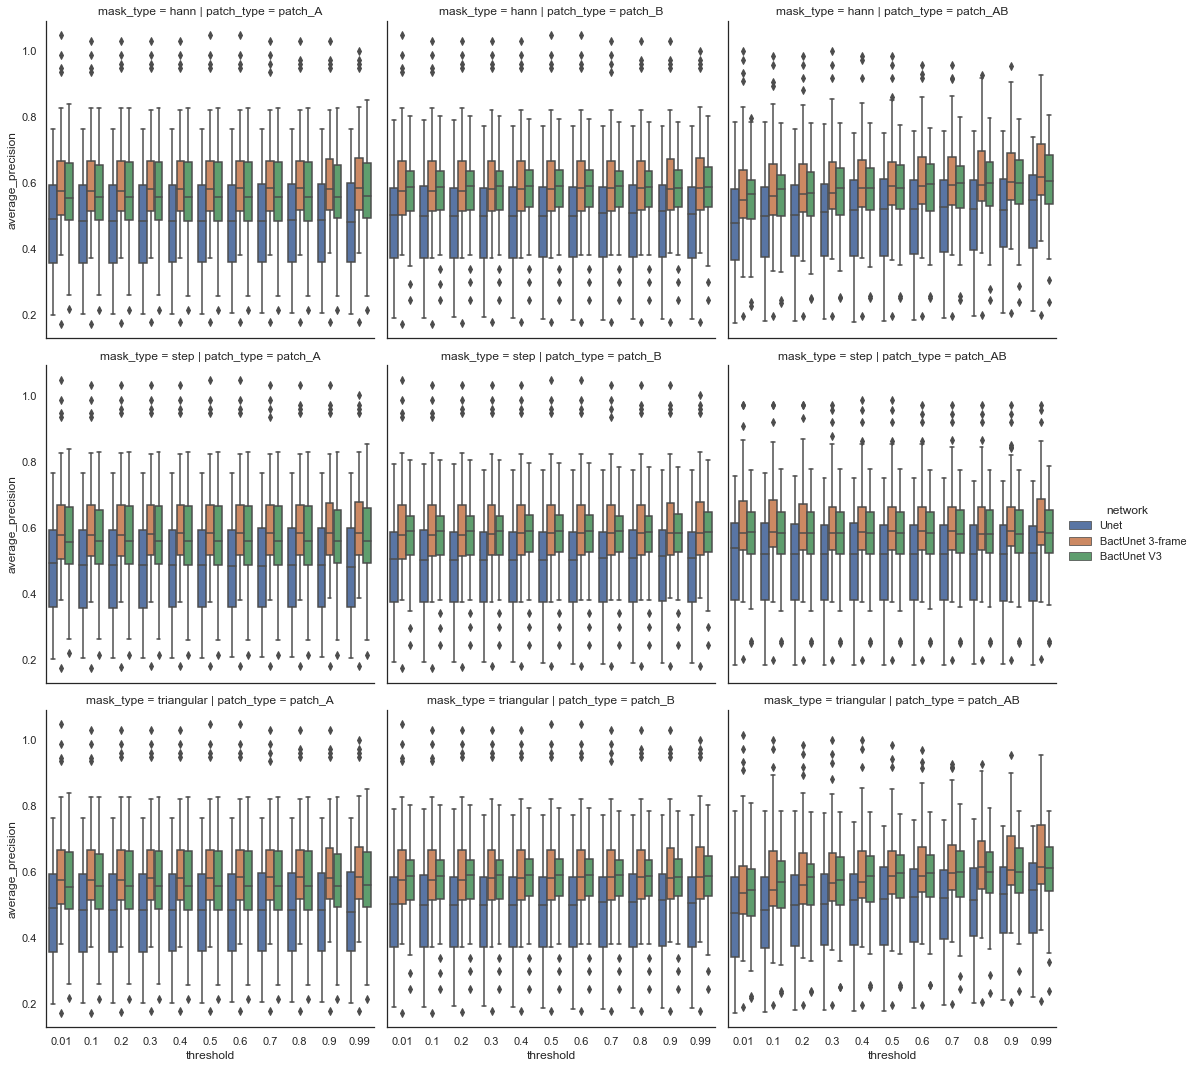

In [149]:
plt.figure(figsize=(20,20))

g = sns.catplot(data=data_df.loc[(data_df['dataset'] == 'validation')]
                , x='threshold', y='average_precision', hue='network',
                col='patch_type', row='mask_type', kind="box")

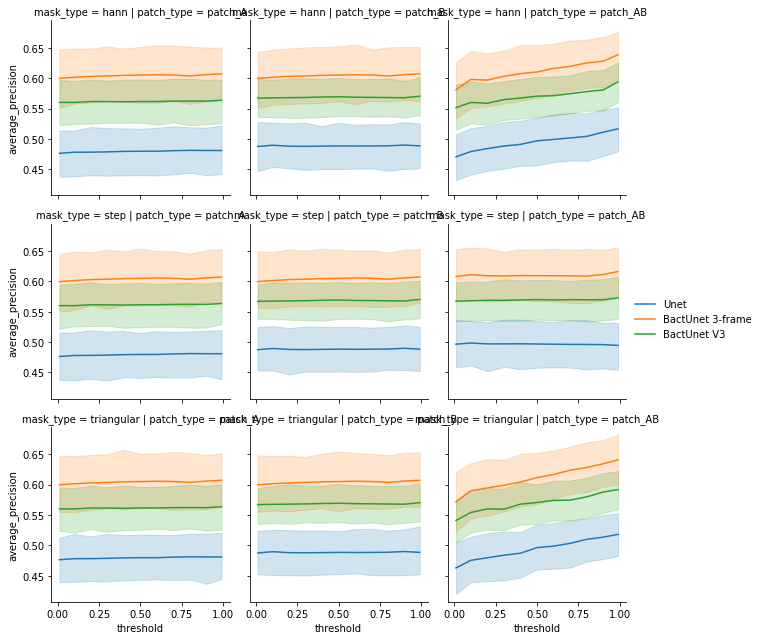

In [121]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'validation')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'average_precision', 'network')
g.add_legend()

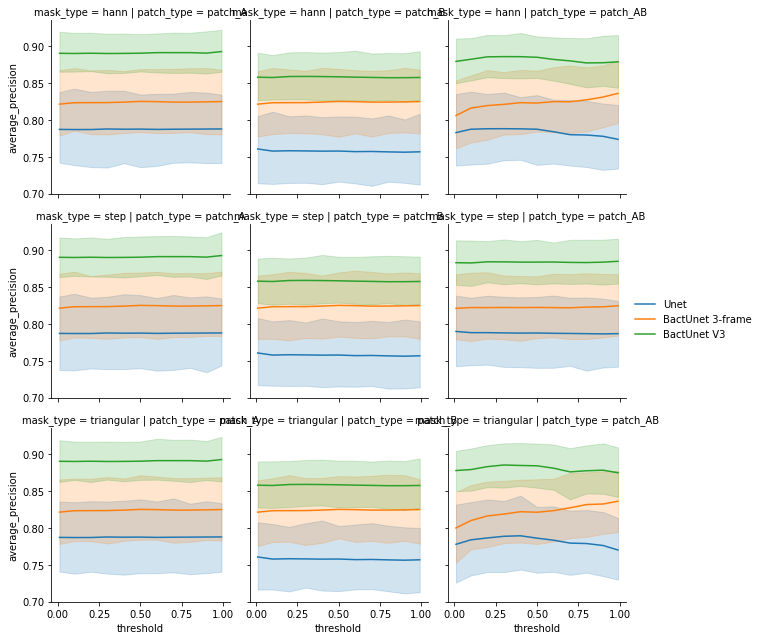

In [122]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'training')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'average_precision', 'network')
g.add_legend()

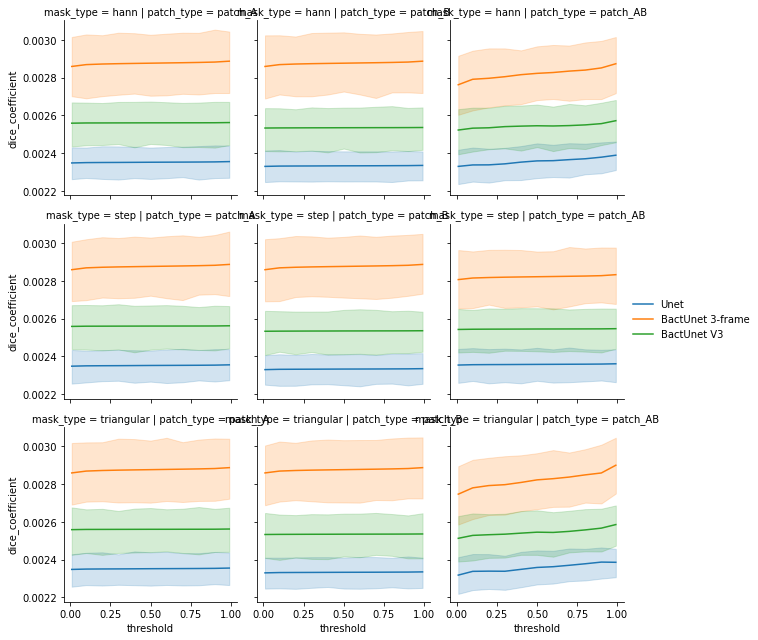

In [117]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'validation')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'dice_coefficient', 'network')
g.add_legend()

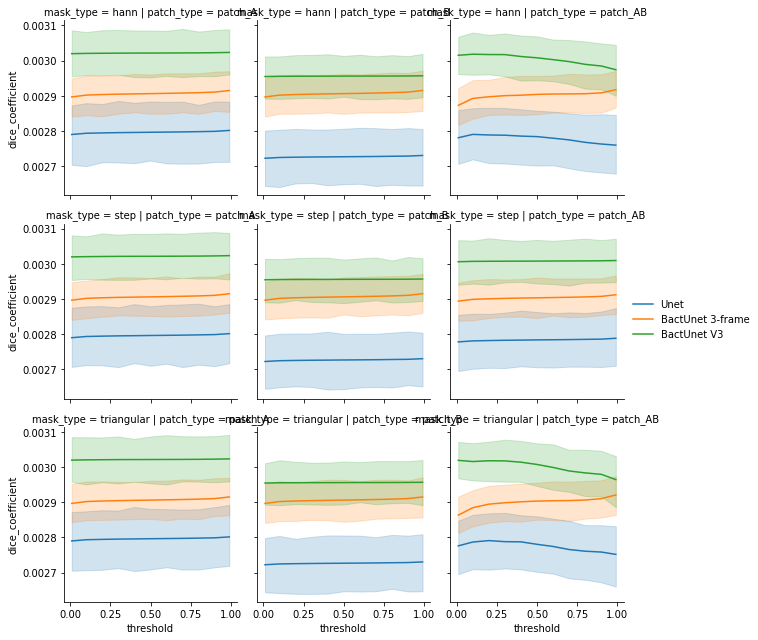

In [120]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'training')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'dice_coefficient', 'network')
g.add_legend()

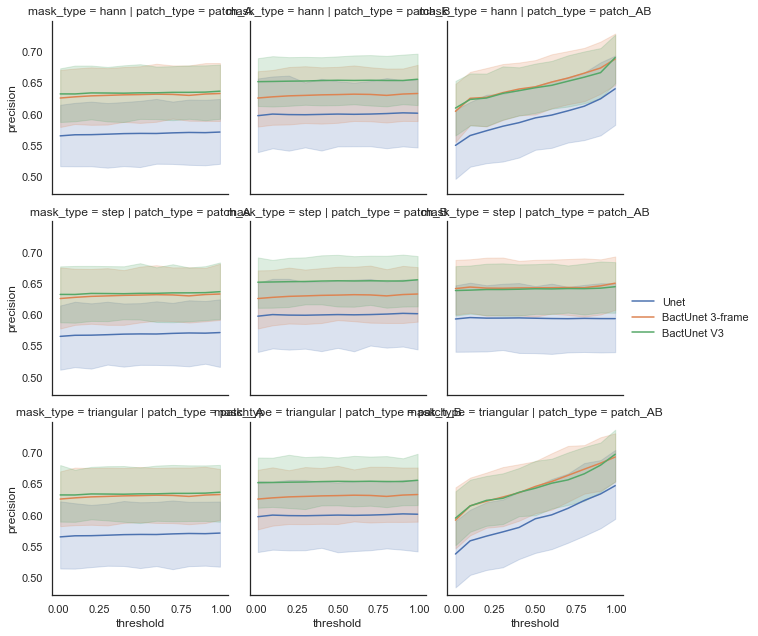

In [166]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'validation')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'precision', 'network')
g.add_legend()

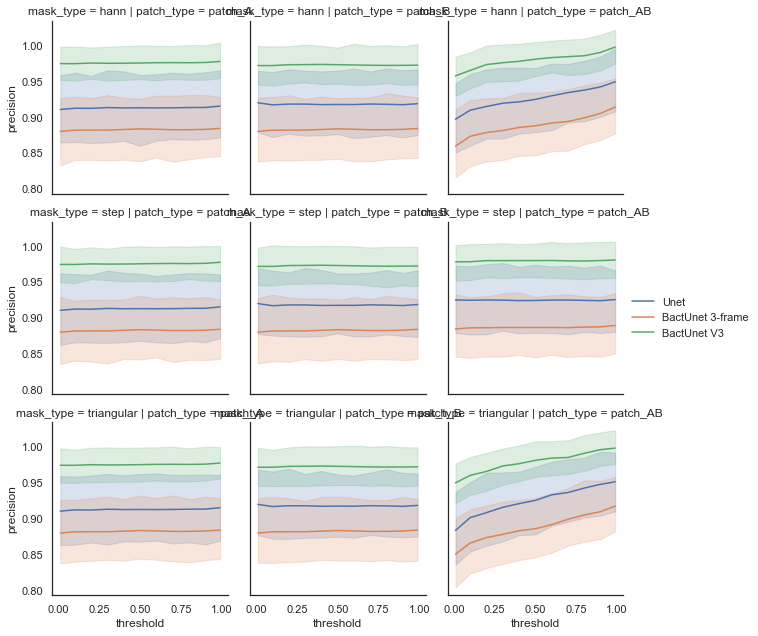

In [167]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'training')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'precision', 'network')
g.add_legend()

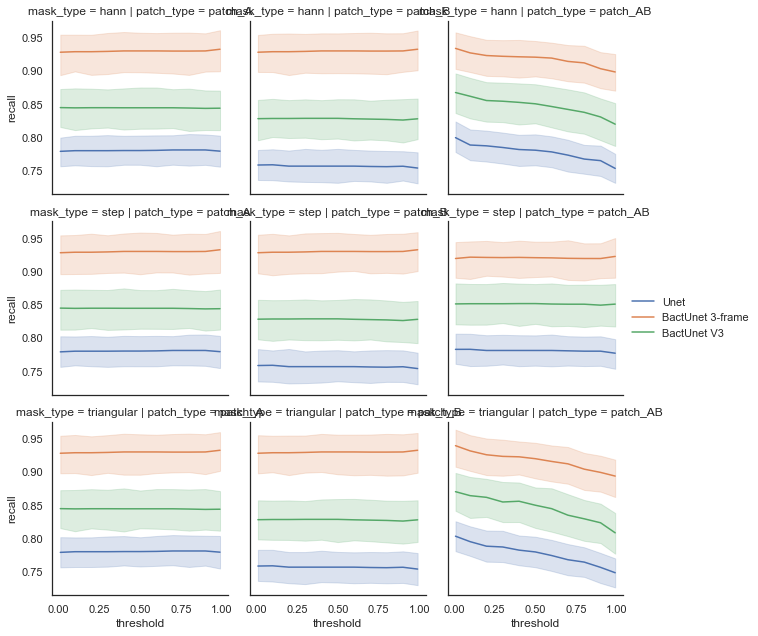

In [168]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'validation')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'recall', 'network')
g.add_legend()

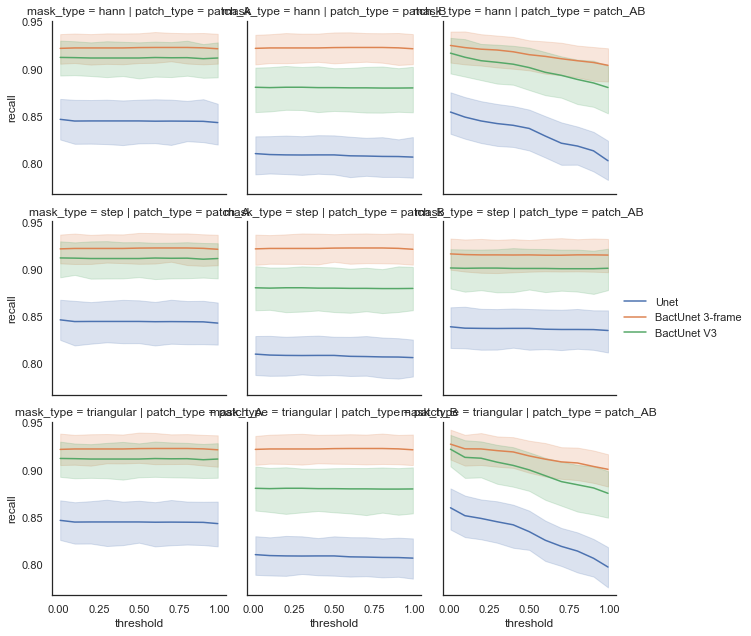

In [169]:
g = sns.FacetGrid(data=data_df.loc[(data_df['dataset'] == 'training')], col='patch_type', row='mask_type')
g.map(sns.lineplot, 'threshold', 'recall', 'network')
g.add_legend()

C:\Users\Jens\miniconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\Jens\miniconda3\envs\tensorflow\lib\site-packages\seaborn\axisgrid.py:675: UserWarning: Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


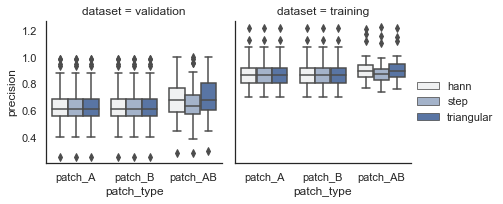

In [162]:

g = sns.FacetGrid(data=data_df.loc[(data_df['threshold'] == 0.99) & (data_df['network']=='BactUnet 3-frame')],
                  col='dataset')
g.map(sns.boxplot, 'patch_type', 'precision', 'mask_type')

#sns.set(rc={'figure.figsize':(20,10)})
g.add_legend()


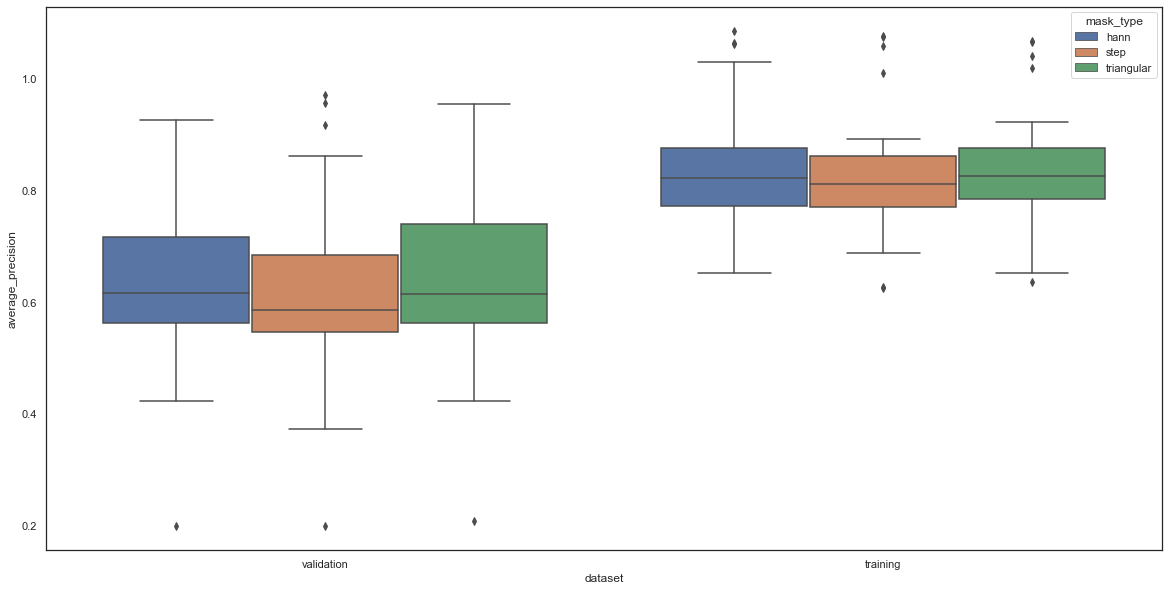

In [153]:
plt.figure(figsize=(20,10))
#sns.set_style('white')
g3 = sns.boxplot(data=data_df.loc[(data_df['threshold'] == 0.99) & (data_df['network']=='BactUnet 3-frame') &
                                 (data_df['patch_type']=='patch_AB')],
                 x='dataset', y='average_precision', hue='mask_type')


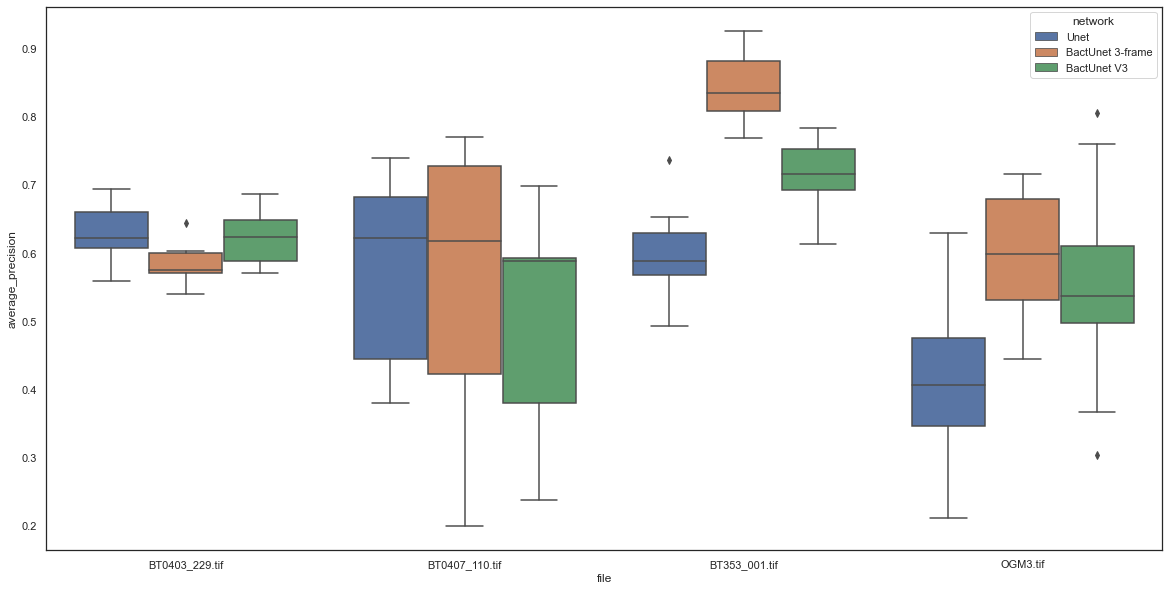

In [154]:
plt.figure(figsize=(20,10))
#sns.set_style('white')
g3 = sns.boxplot(data=data_df.loc[(data_df['threshold'] == 0.99) & (data_df['mask_type']=='hann') &
                                 (data_df['patch_type']=='patch_AB') & (data_df['dataset']=='validation')],
                 x='file', y='average_precision', hue='network')

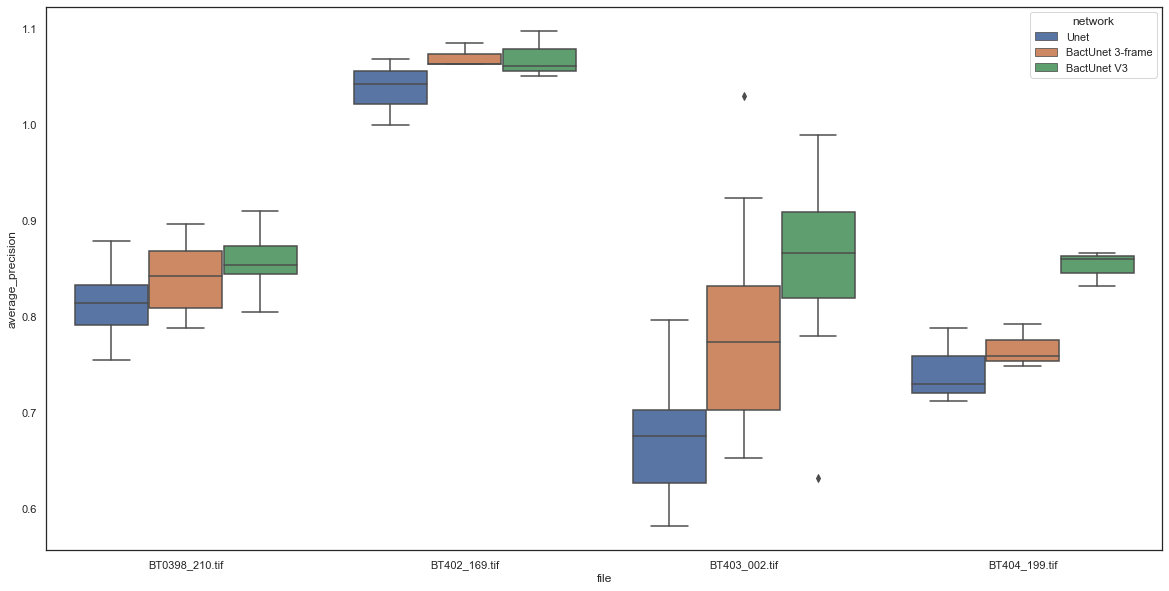

In [155]:
plt.figure(figsize=(20,10))
#sns.set_style('white')
g3 = sns.boxplot(data=data_df.loc[(data_df['threshold'] == 0.99) & (data_df['mask_type']=='hann') &
                                 (data_df['patch_type']=='patch_AB') & (data_df['dataset']=='training')],
                 x='file', y='average_precision', hue='network')

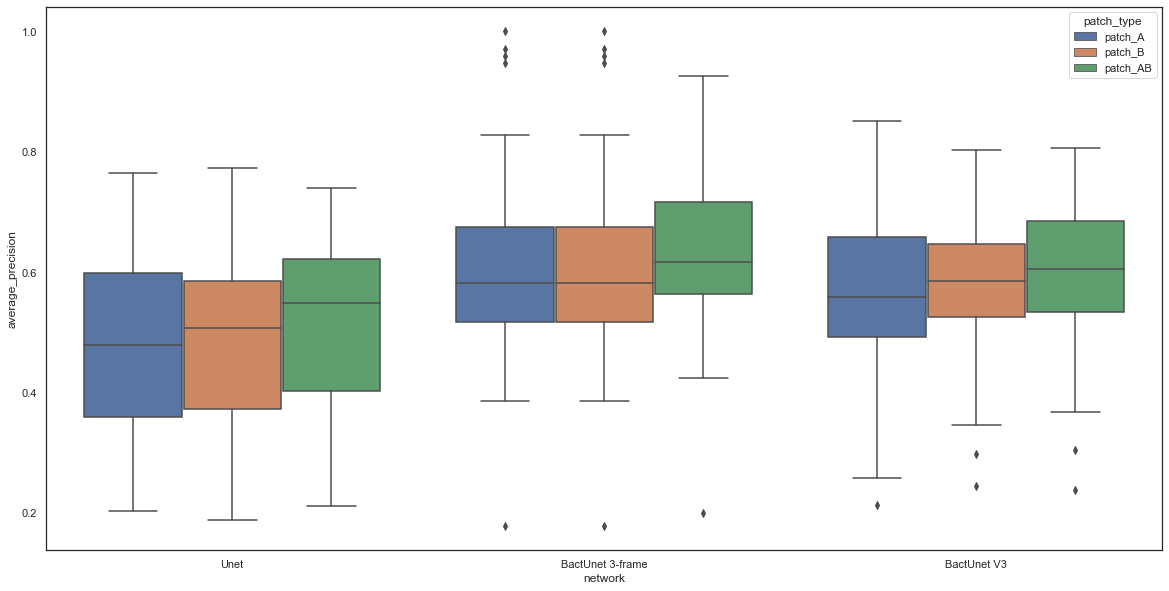

In [177]:
plt.figure(figsize=(20,10))
#sns.set_style('white')
g3 = sns.boxplot(data=data_df.loc[(data_df['threshold'] == 0.99) & (data_df['mask_type']=='hann') &
                                  (data_df['dataset']=='validation')],
                 x='network', y='average_precision', hue='patch_type')